In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from hyperopt import hp, fmin, tpe, Trials
import itertools

In [2]:
train = '/mnt/NewVolume/DUMP/Notebook/xray_analytics_cnn/data/BoneFractureDataset/training'
test = '/mnt/NewVolume/DUMP/Notebook/xray_analytics_cnn/data/BoneFractureDataset/testing'

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#Preprocessing

In [4]:
def scale_images(x, y):
    return x / 255, y

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(train, image_size=(256, 256), labels="inferred", label_mode="binary", validation_split=0.2, subset="training",seed=42)
train_data = train_data.map(scale_images)
train_size = int(len(train_data))
train_data_final = train_data.take(train_size)
print(train_size)

Found 8863 files belonging to 2 classes.
Using 7091 files for training.
222


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(train, image_size=(256, 256), labels="inferred", label_mode="binary", validation_split=0.2, subset="validation", seed=42)
val_data = val_data.map(scale_images)
val_data_final = val_data.take(len(val_data))
print(len(val_data))

Found 8863 files belonging to 2 classes.
Using 1772 files for validation.
56


In [7]:
#The Model

In [11]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from hyperopt import hp, fmin, tpe, Trials
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(AveragePooling2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

optimizer = RMSprop(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 average_pooling2d_1 (Averag  (None, 127, 127, 16)     0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train_data_final, epochs=10, validation_data=val_data_final, callbacks=[early_stopping],verbose=1)

Epoch 1/10
222/222 [==============================] - 24s 108ms/step - loss: 0.3215 - accuracy: 0.8659 - val_loss: 0.2228 - val_accuracy: 0.9153
Epoch 2/10
222/222 [==============================] - 24s 108ms/step - loss: 0.1643 - accuracy: 0.9389 - val_loss: 0.1312 - val_accuracy: 0.9543
Epoch 3/10
222/222 [==============================] - 24s 107ms/step - loss: 0.0879 - accuracy: 0.9695 - val_loss: 0.8458 - val_accuracy: 0.7833
Epoch 4/10
222/222 [==============================] - 24s 107ms/step - loss: 0.0548 - accuracy: 0.9791 - val_loss: 0.0712 - val_accuracy: 0.9780
Epoch 5/10
222/222 [==============================] - 24s 107ms/step - loss: 0.0369 - accuracy: 0.9877 - val_loss: 0.2492 - val_accuracy: 0.9357
Epoch 6/10
222/222 [==============================] - 24s 107ms/step - loss: 0.0295 - accuracy: 0.9915 - val_loss: 0.0551 - val_accuracy: 0.9836
Epoch 7/10
222/222 [==============================] - 24s 108ms/step - loss: 0.0257 - accuracy: 0.9932 - val_loss: 0.0769 - val_ac

In [19]:
model.save('newest.h5')

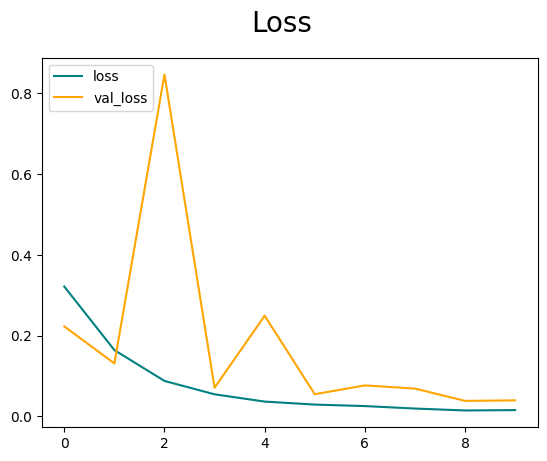

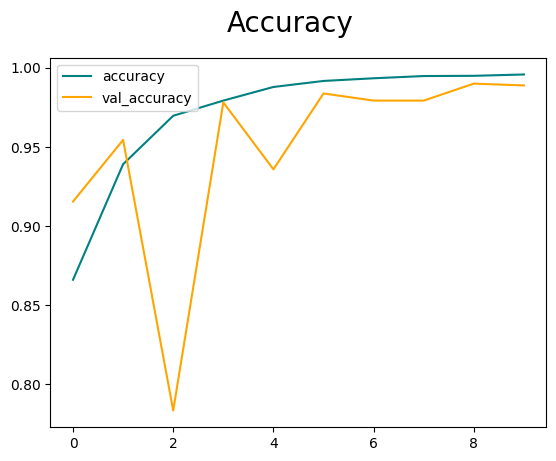

In [16]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()